# Explore Data in Experiment `20211202_72bar`

Note that the thresholds for analysis were determined based on `bubbletracking_koe/analysis/true_obj_vs_threshold.py`

In [1]:
%load_ext autoreload
%autoreload 2

# sets plotting font to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# standard libraries
import os
import glob
import pickle as pkl

# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt

# custom libraries
import sys
sys.path.append('../../libs/')
import fn
import flow
import plot.bubble as pltb
from conversions import *

# comes after imports from ../../libs/ because I unfortunately 
# created files with the same name there and in ../src/
sys.path.append('../src/')
import objproc as op
import bubble
import analytics as an

### PARAMETERS ###
# directory template containing data files
data_dir_tmp = '../input/ppg_co2/20211202_72bar/*'
# data filename
data_filename = 'data.pkl'
# data for polyol-CO2 mixture 
# make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
polyol_data_file = '../input/3k2f_31c.csv'
# equation of state data for CO2 at desired temperature 
eos_co2_file = '../input/eos_co2_25-0C.csv'

## Plot Bubble Growth

Just until they start to elongate.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


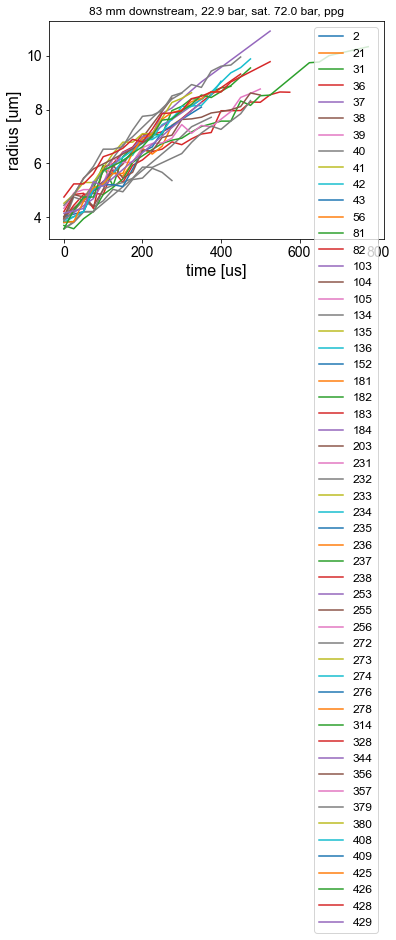

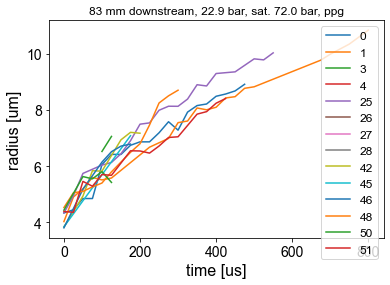

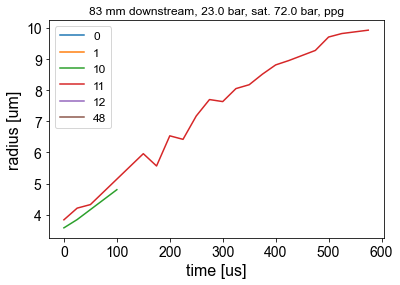

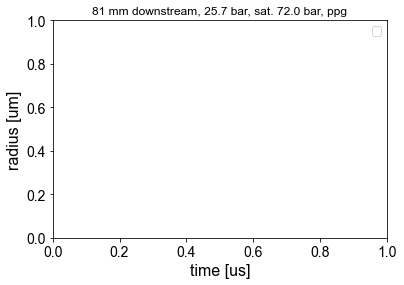

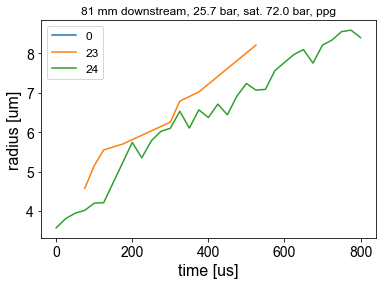

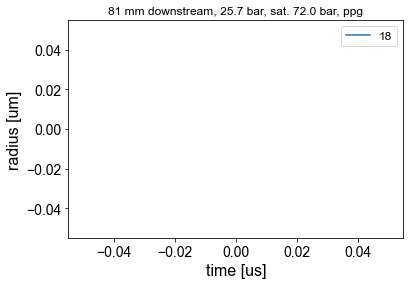

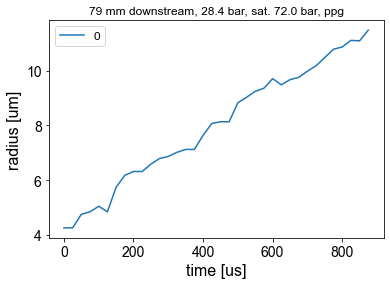

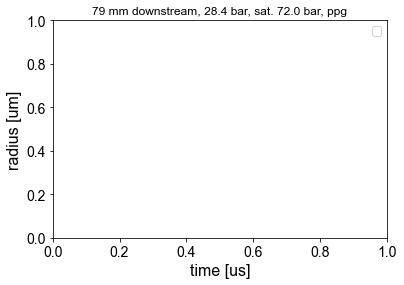

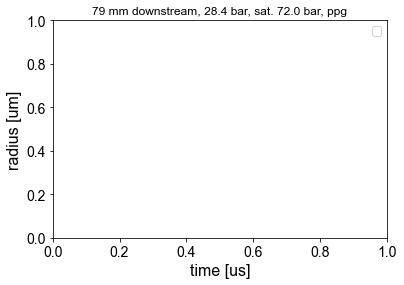

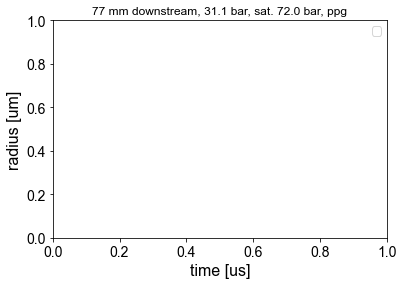

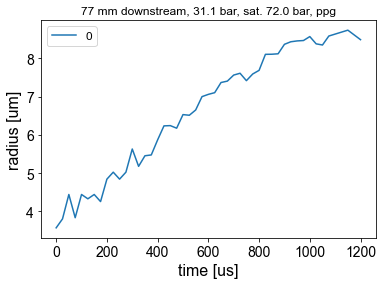

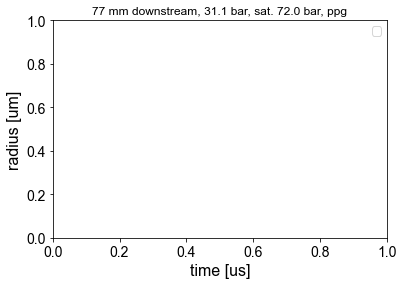

In [2]:
# plot parameters
ax_fs = 16
tk_fs = 14
l_fs = 12
# analysis parameters
W_frac = 0.5 # ignores all bubbles for which width is less than this fraction of length


# data structs to store bubble radii, etc.
# keys will be (num, ID), where num is video number and ID is bubble ID number
# values will be dictionaries of properties: time [s], radius [m], width [m], length [m],
# 
bubble_growth = {}

# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions
    # saturation pressure, distance along capillary, 
    # estimated local pressure, polyol
    p_sat, p_est, d, polyol = op.get_conditions(data['metadata'])

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
        
        # gets timeline of bubble (starts at zero) [s]
        frame_list = obj['props_raw']['frame']
        fps = obj['metadata']['fps']
        t = (np.asarray(frame_list) - frame_list[0]) / fps
        
        # gets bubble size
        R = np.asarray(obj['props_proc']['radius [um]'])
        L = np.asarray(op.calc_L(obj))
        W = np.asarray(op.calc_W(obj))
        
        # gets valid indices (eliminates where on border or where bubble is too long
        not_on_border = np.logical_not(np.asarray(obj['props_raw']['on border']))
        not_too_long = W > L*W_frac
        idx = np.logical_and(not_on_border, not_too_long)
        
        # plots bubble growth
        ax.plot(t[idx]*s_2_us, R[idx], label=str(ID))
        
        
    # formats plot
    ax.set_xlabel('time [us]', fontsize=ax_fs)
    ax.set_ylabel('radius [um]', fontsize=ax_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    ax.legend(fontsize=l_fs)
    ax.set_title('{0:d} mm downstream, {1:.1f} bar, sat. {2:.1f} bar, {3:s}'\
                 .format(int(d*m_2_mm), p_est*Pa_2_bar, p_sat*Pa_2_bar, polyol))

## Fit Data to Bubble Growth Model to Estimate Nucleation Time

t_nuc = 96.501 ms and error in R is 0.9992.
t_nuc = 95.053 ms and error in R is 1.2208.
t_nuc = 95.777 ms and error in R is 0.5206.
t_nuc = 96.139 ms and error in R is 0.0090.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 96.139 ms
Model prediction at fit point is R = 3.940775 um.


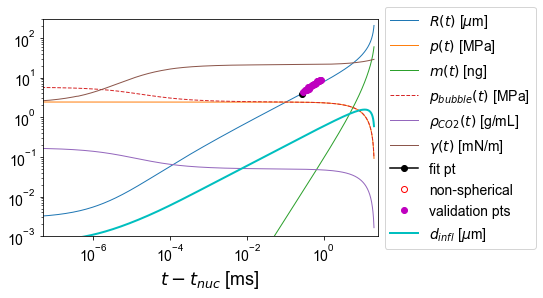

In [3]:
# analysis parameters
W_frac = 0.5 # ignores all bubbles for which width is less than this fraction of length
frac_lo = 0.97
frac_hi = 1.03
growth_fn = bubble.grow

# Epstein--Plesset params
# bubble growth model parameters
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]

# guess for effective diffusivity constant [m^2/s] TODO: fit this, too
D = 4E-9

# other params
i_t_nuc = 0
sigma_R = 0.01
max_iter = 25
i_t = 0
i_R = 8
dict_args = {'D' : D}


# number of bubbles to fit
n_fit = 1
ct = 0


# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    # loads data
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions
    # saturation pressure, distance along capillary, 
    # estimated local pressure, polyol
    p_sat, p_est, d, polyol = op.get_conditions(data['metadata'])
    L = data['metadata']['L'] # length of observation capillary [m]
    p_in = -data['metadata']['object_kwargs']['dp'] # inlet pressure est w flow eqns [Pa]
    v_max = data['metadata']['object_kwargs']['v_max'] # centerline speed [m/s] est w flow eqns
    
    # computes time to reach center of field of view
    t_center = d / v_max

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
            
        # time of observations of bubble since entering observation capillary [s]
        t_bub = op.calc_t(obj, d, v_max)
        
        # gets bubble size [um]
        W_bub = np.asarray(op.calc_W(obj))
        L_bub = np.asarray(op.calc_L(obj))
        # and radius [m]
        R_bub = np.asarray(obj['props_proc']['radius [um]']) * um_2_m
        
        # gets valid indices (eliminates where on border or where bubble is too long
        not_on_border = np.logical_not(np.asarray(obj['props_raw']['on border']))
        not_too_long = W_bub > L_bub * W_frac
        idx = np.logical_and(not_on_border, not_too_long)
        if not any(idx):
            continue
        
        # extracts only valid measurements
        t_bub = t_bub[idx]
        R_bub = R_bub[idx]
        
        # estimates bounds on nucleation time [s]
        t_nuc_lo = frac_lo*t_center
        t_nuc_hi = frac_hi*t_center
        
        # collects inputs
        eps_params = list((dt, p_sat, R_nuc, L, p_in, v_max, polyol_data_file, eos_co2_file))

        # fits nucleation time to data [s]
        t_nuc, output = an.fit_growth_to_pt(t_bub[0], R_bub[0], t_nuc_lo, t_nuc_hi, 
                                            growth_fn, eps_params, i_t_nuc, sigma_R=sigma_R, 
                                            max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)
        # plots result
        R_i = data['metadata']['object_kwargs']['R_i'] # inner stream radius [m]
        ax = pltb.fit(t_nuc, output, t_bub, R_bub, R_i)
        
        ####### FIT D ######
             
        # ends loop when desired number of trajectories has been fit
        ct += 1
        if ct == n_fit:
            break
            
    if ct == n_fit:
        break

## Fit Diffusivity as Well as Nucleation Time

t_nuc = 96.501 ms and error in R is 0.9992.
t_nuc = 95.053 ms and error in R is 1.3193.
t_nuc = 95.777 ms and error in R is 0.6480.
t_nuc = 96.139 ms and error in R is 0.0699.
t_nuc = 96.320 ms and error in R is 0.3712.
t_nuc = 96.229 ms and error in R is 0.1222.
t_nuc = 96.184 ms and error in R is 0.0223.
t_nuc = 96.161 ms and error in R is 0.0210.
t_nuc = 96.173 ms and error in R is 0.0043.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 96.173 ms
D = 4.5e-09 m^2/s. rms = 0.026 is BELOW tolerance of 0.030.
Model prediction at fit point is R = 3.913618 um.
t_nuc = 96.501 ms and error in R is 1.0933.
t_nuc = 97.948 ms and error in R is 0.9992.
t_nuc = 97.224 ms and error in R is 0.0964.
t_nuc = 96.862 ms and error in R is 0.6156.
t_nuc = 97.043 ms and error in R is 0.3196.
t_nuc = 97.134 ms and error in R is 0.1138.
t_nuc = 97.179 ms and error in R is 0.0043.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 97.179 ms
D = 4.5e-09 m^

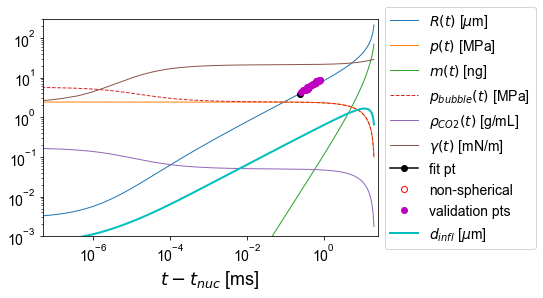

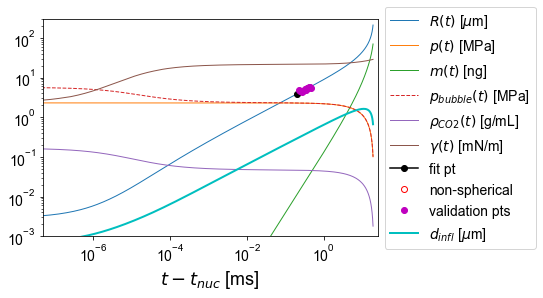

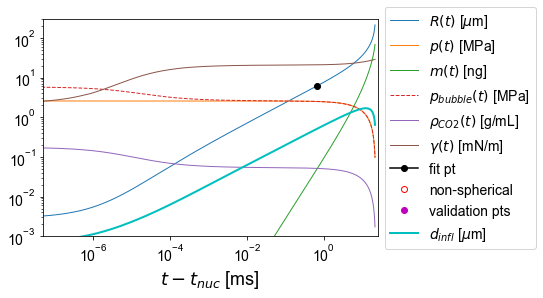

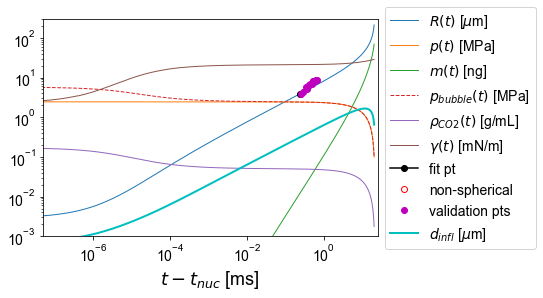

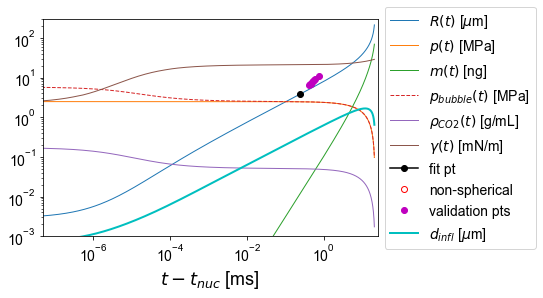

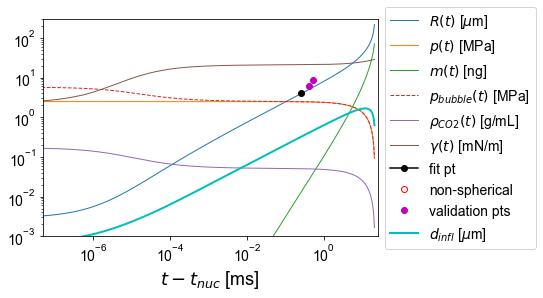

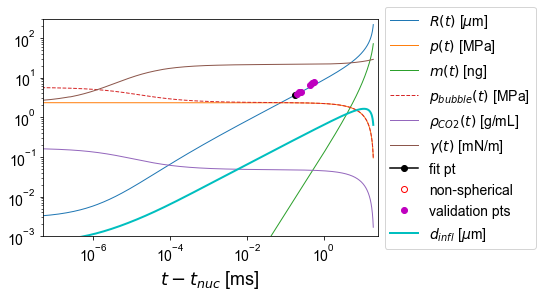

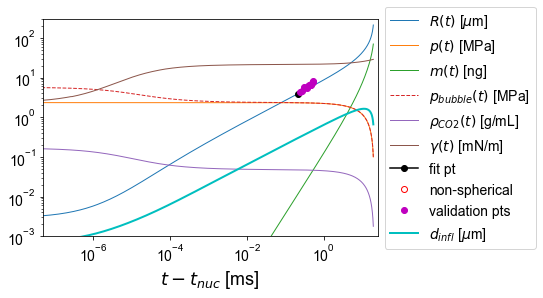

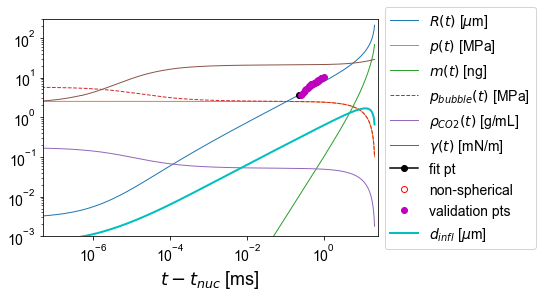

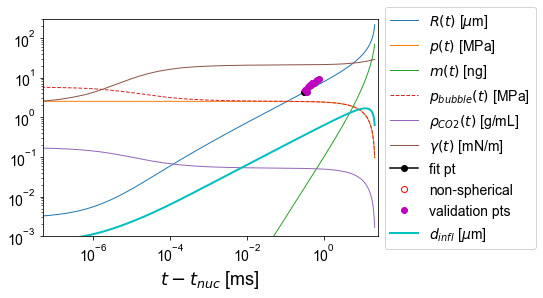

In [15]:
# analysis parameters
W_frac = 0.5 # ignores all bubbles for which width is less than this fraction of length
frac_lo = 0.97
frac_hi = 1.03
growth_fn = bubble.grow

# Epstein--Plesset params
# bubble growth model parameters
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]

# guess for effective diffusivity constant [m^2/s] TODO: fit this, too
D_min = 1E-9
D_max = 8E-9

# other params
i_t_nuc = 0
sigma_R = 0.01
rms_tol = 0.01 # keep high--this is used to fit D, must allow for noise in data
max_iter = 25
i_t = 0
i_R = 8
dict_args = {'D' : D}


# number of bubbles to fit
n_fit = 10
ct = 0


# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    # loads data
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions
    # saturation pressure, distance along capillary, 
    # estimated local pressure, polyol
    p_sat, p_est, d, polyol = op.get_conditions(data['metadata'])
    L = data['metadata']['L'] # length of observation capillary [m]
    p_in = -data['metadata']['object_kwargs']['dp'] # inlet pressure est w flow eqns [Pa]
    v_max = data['metadata']['object_kwargs']['v_max'] # centerline speed [m/s] est w flow eqns
    
    # computes time to reach center of field of view
    t_center = d / v_max

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
            
        # time of observations of bubble since entering observation capillary [s]
        t_bub = op.calc_t(obj, d, v_max)
        
        # gets bubble size [um]
        W_bub = np.asarray(op.calc_W(obj))
        L_bub = np.asarray(op.calc_L(obj))
        # and radius [m]
        R_bub = np.asarray(obj['props_proc']['radius [um]']) * um_2_m
        
        # gets valid indices (eliminates where on border or where bubble is too long
        not_on_border = np.logical_not(np.asarray(obj['props_raw']['on border']))
        not_too_long = W_bub > L_bub * W_frac
        idx = np.logical_and(not_on_border, not_too_long)
        if not any(idx):
            continue
        
        # extracts only valid measurements
        t_bub = t_bub[idx]
        R_bub = R_bub[idx]
        
        # estimates bounds on nucleation time [s]
        t_nuc_lo = frac_lo*t_center
        t_nuc_hi = frac_hi*t_center

        # sets moveable limits on effective diffusivity for binary search
        D_min_tmp = D_min
        D_max_tmp = D_max
        for ct_iter in range(max_iter):
            
            # makes guess for effective diffusivity constant
            D = (D_min_tmp + D_max_tmp) / 2
            # packages it for solver
            dict_args = {'D' : D}
            
            # collects inputs -- must recollect after an.fit_growth_to_pt b/c it inserts t_nuc
            eps_params = list((dt, p_sat, R_nuc, L, p_in, v_max, polyol_data_file, eos_co2_file))
            
            # fits nucleation time to data [s]
            t_nuc, output = an.fit_growth_to_pt(t_bub[0], R_bub[0], t_nuc_lo, t_nuc_hi, 
                                                growth_fn, eps_params, i_t_nuc, sigma_R=sigma_R, 
                                                max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)
            
            # evaluates root mean square error
            rms_err = an.compute_rms_err(t_bub, R_bub, output)
            
            # rms from t^1/2 fit
            t_fit = output[0]
            R_fit = output[-2]
            slope_fit, const = np.polyfit( np.sqrt(t_fit - t_nuc), R_fit, 1 )
            R_sqrt_t = slope_fit*np.sqrt(t_fit - t_nuc) + const
            rms_data = an.compute_rms_err(t_fit, R_sqrt_t, output)
            rms_excess = rms_err - rms_data
            
            if rms_excess < rms_tol:
                print('D = {0:g} m^2/s. rms = {1:.3f} is BELOW tolerance of {2:.3f}.'.format(D, rms_excess, rms_tol))
                break
            else:
                print('D = {0:g} m^2/s. rms = {1:.3f} is ABOVE tolerance of {2:.3f}.'.format(D, rms_excess, rms_tol))
                # compares slopes of fit and data
                slope_meas, _ = np.polyfit( np.sqrt(t_bub - t_nuc), R_bub, 1 )
                # decreases D if fitted slope is too high
                if slope_fit > slope_meas:
                    D_max_tmp = D
                # increases D if fitted slope is too low
                else:
                    D_min_tmp = D
                
            
        # plots result
        R_i = data['metadata']['object_kwargs']['R_i'] # inner stream radius [m]
        ax = pltb.fit(t_nuc, output, t_bub, R_bub, R_i)
        
        # stores results -- TODO
        # t_nuc, d_nuc, output, D
             
        # ends loop when desired number of trajectories has been fit
        ct += 1
        if ct == n_fit:
            break
            
    if ct == n_fit:
        break